In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy.linalg import inv, eig, svd
from numpy.random import uniform, randn, seed
from itertools import repeat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

pd.options.display.float_format = '{:,.2f}'.format
seed(42)

In [2]:
def format3D(axis, labels=('x', 'y', 'z'), limits=None):
    """3D plot helper function to set labels, pane color, and axis limits"""
    axis.set_xlabel('\n${}$'.format(labels[0]), linespacing=3)
    axis.set_ylabel('\n${}$'.format(labels[1]), linespacing=3)
    axis.set_zlabel('\n${}$'.format(labels[2]), linespacing=3)
    transparent = (1.0, 1.0, 1.0, 0.0)
    axis.w_xaxis.set_pane_color(transparent)
    axis.w_yaxis.set_pane_color(transparent)
    axis.w_zaxis.set_pane_color(transparent)
    if limits:
        axis.set_xlim(limits[0])
        axis.set_ylim(limits[1])
        axis.set_zlim(limits[2])

## Create a noisy 3D Ellipse

In [3]:
n_points, noise = 100, 0.1
angles = uniform(low=-np.pi, high=np.pi, size=n_points)
x = 2 * np.cos(angles) + noise * randn(n_points)
y = np.sin(angles) + noise * randn(n_points)

theta = np.pi/4 # 45 degree rotation
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                            [np.sin(theta), np.cos(theta)]])

rotated = np.column_stack((x, y)).dot(rotation_matrix)
x, y = rotated[:, 0], rotated[:, 1]

z = .2 * x  + .2 * y + noise * randn(n_points)
data = np.vstack((x, y, z)).T

In [4]:
data.shape

(100, 3)

### Plot the result 

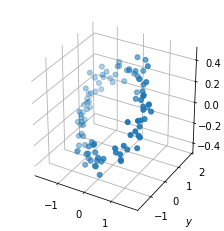

In [5]:
ax = plt.figure().gca(projection='3d')
ax.set_aspect('equal')
ax.scatter(x, y, z, s=25)
format3D(ax)
# plt.gcf().set_size_inches(12,12)
# plt.tight_layout();

## Principal Components using scikit-learn

In [6]:
pca = PCA()
pca.fit(data)
C = pca.components_.T # columns = principal components
C

array([[ 0.71409739,  0.66929454,  0.20520656],
       [-0.70000234,  0.68597301,  0.1985894 ],
       [ 0.00785136,  0.28545725, -0.95835928]])

### First principal component

In [7]:
C[:, 0]

array([ 0.71409739, -0.70000234,  0.00785136])

### Explained Variance

In [8]:
explained_variance = pca.explained_variance_
explained_variance

array([1.92923132, 0.55811089, 0.00581353])

In [9]:
np.allclose(explained_variance/np.sum(explained_variance), 
            pca.explained_variance_ratio_)

True

### PCA to reduce dimensions

In [10]:
pca2 = PCA(n_components=2)
projected_data  = pca2.fit_transform(data)
projected_data.shape

(100, 2)

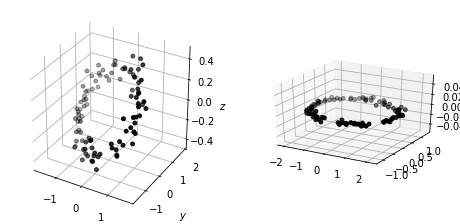

In [13]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_aspect('equal')
ax1.scatter(x, y, z, s=15, c='k')
format3D(ax1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_aspect('equal')
ax2.scatter(*projected_data.T, s=15, c='k')
format3D(ax1)

In [14]:
pca2.explained_variance_ratio_

array([0.77381099, 0.22385721])

## Principal Components from Covariance Matrix

- The covariance matrix is based on: $cov_{x,y}=\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N-1}$

In [15]:
cov = np.cov(data.T) # each row represents a feature
cov.shape

(3, 3)

### Eigendecomposition: Eigenvectors & Eigenvalues 

- The Eigenvectors $w_i$ and Eigenvalues $\lambda_i$ for a square matrix $M$ are defined as follows:
$$M w_i = \lambda_i w_i$$

- This implies we can represent the matrix $M$ using Eigenvectors and Eigenvalues, where $W$ is a matrix that contains the Eigenvectors as column vectors, and $L$ is a matrix that contains the $\lambda_i$ as diagonal entries (and 0s otherwise):
$$M=WLW^{-1}$$

In [16]:
eigen_values, eigen_vectors = eig(cov)

### eigenvectors = principal components 

In [17]:
eigen_vectors

array([[ 0.71409739, -0.66929454, -0.20520656],
       [-0.70000234, -0.68597301, -0.1985894 ],
       [ 0.00785136, -0.28545725,  0.95835928]])

In [18]:
np.allclose(np.abs(C), np.abs(eigen_vectors))

True

#### eigenvalues = explained variance 

In [19]:
eigen_values

array([1.92923132, 0.55811089, 0.00581353])

In [20]:
np.allclose(explained_variance, eigen_values)

True

#### Check that Eigendecomposition works

In [21]:
ev = np.zeros((3, 3))
np.fill_diagonal(ev, eigen_values)
ev # diagonal matrix

array([[1.92923132, 0.        , 0.        ],
       [0.        , 0.55811089, 0.        ],
       [0.        , 0.        , 0.00581353]])

In [22]:
decomposition = eigen_vectors.dot(ev).dot(inv(eigen_vectors))
np.allclose(cov, decomposition)

True

### Preferred: Singular Value Decomposition

#### Requires centering your data! 

In [23]:
n_features = data.shape[1]
data_ = data - data.mean(axis=0)

In [24]:
cov_manual = data_.T.dot(data_)/(len(data)-1)
np.allclose(cov_manual, cov)

True

In [25]:
U, s, Vt = svd(data_)
U.shape, s.shape, Vt.shape

((100, 100), (3,), (3, 3))

In [26]:
# Convert s from vector to diagonal matrix
S = np.zeros_like(data_)
S[:n_features, :n_features] = np.diag(s)
S.shape

(100, 3)

#### Show that the result indeed decomposes the original data

In [27]:
np.allclose(data_, U.dot(S).dot(Vt))

True

#### Confirm that $V^T$ contains the principal components 

In [28]:
np.allclose(np.abs(C), np.abs(Vt.T))

True

### Visualize 2D Projection 

In [29]:
pca = PCA(n_components=2)
data_2D = pca.fit_transform(data)

min_, max_ = data[:, :2].min(), data[:, :2].max()
xs, ys = np.meshgrid(np.linspace(min_,max_, n_points), 
                     np.linspace(min_,max_, n_points))

normal_vector = np.cross(pca.components_[0], pca.components_[1])
d = -pca.mean_.dot(normal_vector)
zs = (-normal_vector[0] * xs - normal_vector[1] * ys - d) * 1 / normal_vector[2]

In [30]:
C = pca.components_.T.copy()
proj_matrix = C.dot(inv(C.T.dot(C))).dot(C.T)
C[:,0] *= 2

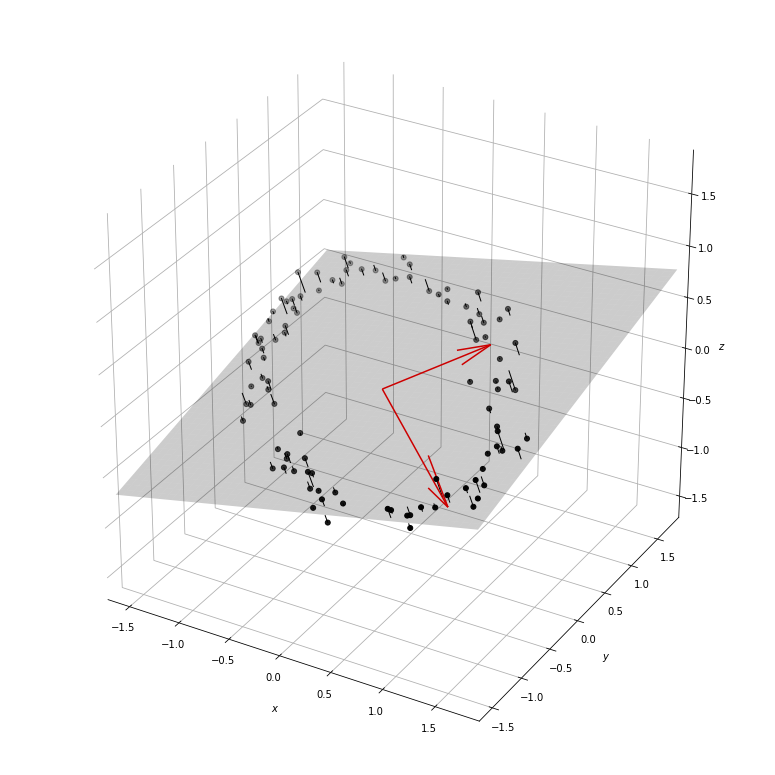

In [32]:
ax = plt.figure(figsize=(14,14)).gca(projection='3d')
ax.set_aspect('equal')

ax.plot_surface(xs, ys, zs, alpha=0.2, color='black',
                linewidth=1, antialiased=True)
ax.scatter(x, y, z, c='k', s=25)

for i in range(n_points):
    ax.plot(*zip(proj_matrix.dot(data[i]), data[i]), 
            color='k', lw=1)

origin = np.zeros((2, 3))
X, Y, Z, U, V, W = zip(*np.hstack((origin, C.T)))
ax.quiver(X, Y, Z, U, V, W, color='red')

format3D(ax, limits=list(repeat((min_, max_), 3)))

### 2D Representation

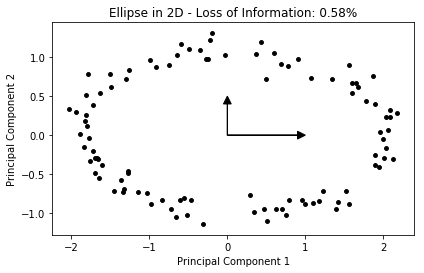

In [33]:
data_3D_inv = pca.inverse_transform(data_2D)
avg_error = np.mean(np.sum(np.square(data_3D_inv-data), axis=1))
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', 
     xlabel='Principal Component 1', 
     ylabel='Principal Component 2', 
     title='Ellipse in 2D - Loss of Information: {:.2%}'.format(avg_error))

ax.scatter(data_2D[:, 0], data_2D[:, 1], color='k', s=15)
ax.arrow(0, 0, 0, .5, head_width=0.1, length_includes_head=True, 
         head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.1, length_includes_head=True, 
         head_length=0.1, fc='k', ec='k')
fig.tight_layout();

### How many Components to represent 64 dimensions?

In [34]:
n_classes = 10
digits = load_digits(n_class=n_classes)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_samples, n_features

(1797, 64)

#### Evaluate the cumulative explained variance 

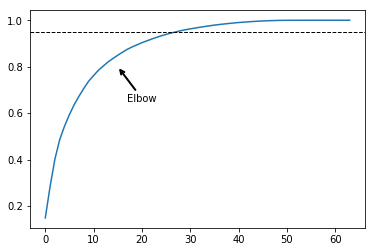

In [35]:
pca = PCA(n_components=64).fit(X)
pd.Series(pca.explained_variance_ratio_).cumsum().plot()
plt.annotate('Elbow', xy=(15, .8), xycoords='data', xytext=(20, .65),
    textcoords='data', horizontalalignment='center',
    arrowprops=dict(color='k', lw=2, arrowstyle="->")
)
plt.axhline(.95, c='k', lw=1, ls='--');

### Automate generation of Components

In [36]:
pca = PCA(n_components=.95).fit(X)
pca.components_.shape

(29, 64)